# Spectral analysis

## Loading of the spectral data and references

In [670]:
import numpy as np

kiwi_spectra = np.loadtxt("results/kiwi_avg_spectra.csv", delimiter=",")
reference_values = np.loadtxt("data/reference.csv", delimiter=",")
wl = np.loadtxt("results/wavelengths.csv", delimiter=",")
reference_values = reference_values[:180, :]
reference_values.shape

(180, 2)

## Outliers removal (unsupervised, PCA)

Due to potential mishaps in our measurements or extraction of spectra per kiwi and various other reasons we may end up having outliers in our dataset. These outliers can cause problems when training chemometrics/machine learning model. Let's explore unsupervised outlier removal

/tmp/ipykernel_1546/1615023657.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')


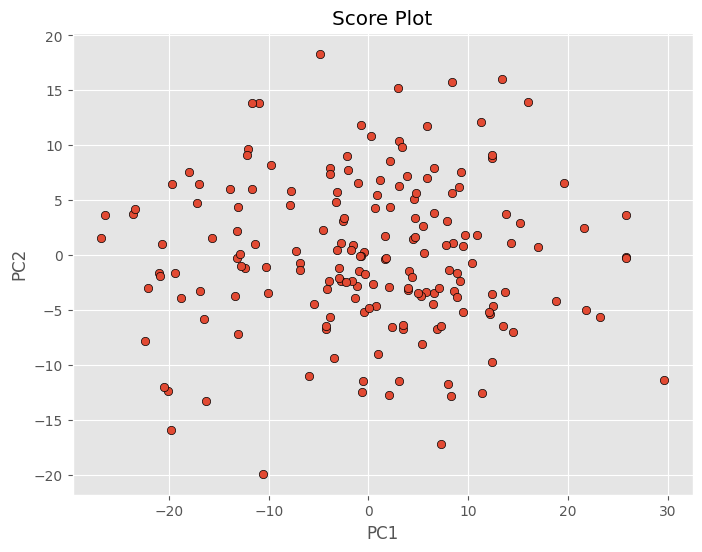

In [671]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

scaler = StandardScaler()
scaled_data = scaler.fit_transform(kiwi_spectra)
 
pca = PCA(random_state=42)
 
# Run PCA on scaled data (since PCA is sensitive to feature scale) and obtain the scores array
T = pca.fit_transform(scaled_data)
 
# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

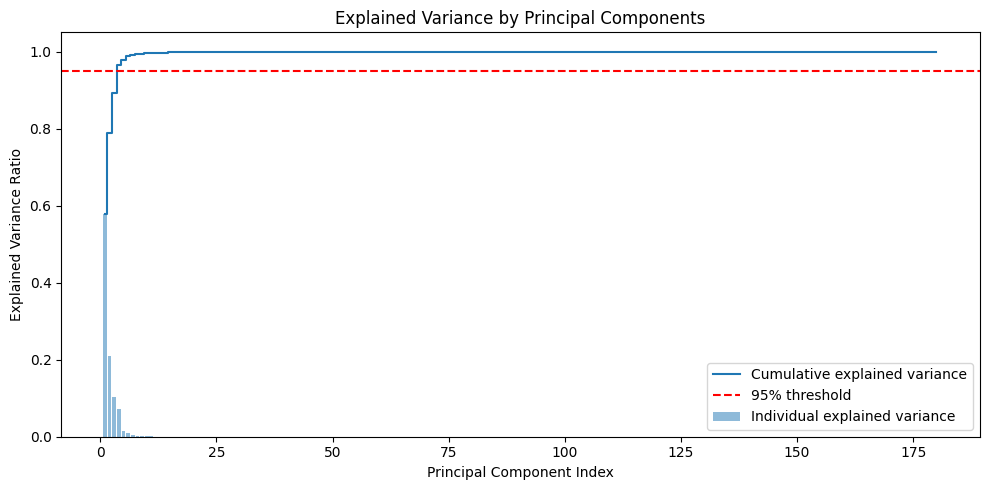

Number of components explaining 95% variance: 4


In [672]:
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var_ratio)+1), explained_var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_var_ratio)+1), cumulative_var_ratio, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumulative_var_ratio >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")

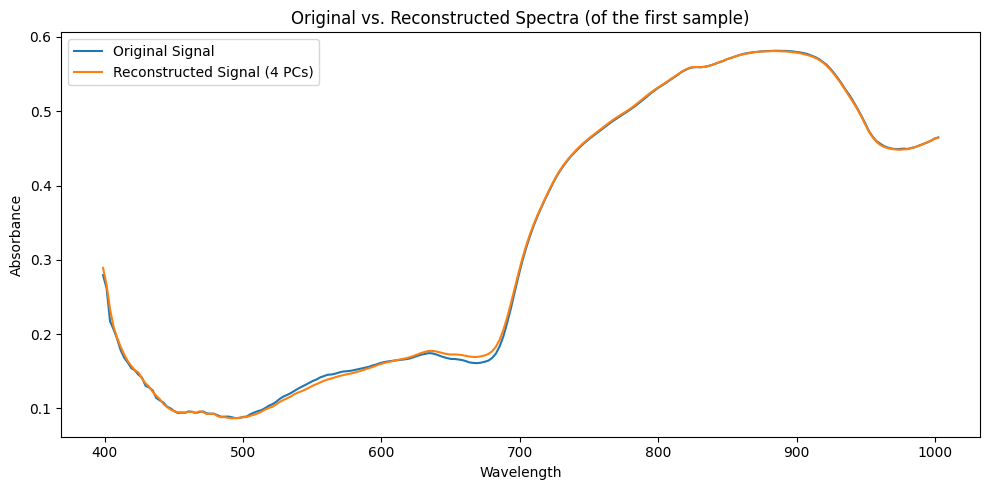

In [673]:
pca_95 = PCA(n_components=n_components_95, random_state=42)
T_95 = pca_95.fit_transform(scaled_data)
reconstructed = pca_95.inverse_transform(T_95)
reconstructed_original_scale = scaler.inverse_transform(reconstructed)

sample_idx = 0  # You can change this index to look at other samples
plt.figure(figsize=(10, 5))
plt.plot(wl, kiwi_spectra[sample_idx], label='Original Signal')
plt.plot(wl, reconstructed_original_scale[sample_idx], label=f'Reconstructed Signal ({n_components_95} PCs)')
plt.title('Original vs. Reconstructed Spectra (of the first sample)')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.legend()
plt.tight_layout()
plt.show()

It's a hard task to analyze every spectra across all wavelengths. By computing principal components we can identify where most of variance in our data is and focus on a few first components. After simplifying our data to first let's say 4 components, we can detect outliers by computing distance of each point to the rest. The straightforward way is to compute Euclidean distance, but:
  - It assumes variables are uncorrelated, which can be misleading when there's correlation between axes (e.g. tilted ellipsoids in PCA score plots).
  - Redundant or correlated variables can distort distance measures, unintentionally amplifying their influence.
  - It is sensitive to outliers, which skew mean and standard deviation—making it hard to identify those same outliers.

**Solution: Mahalanobis Distance**
  - Accounts for the **covariance structure** of the data, giving less weight to directions with high variance (i.e., redundancy).
  - Can be calculated robustly using **Minimum Covariance Determinant (MCD)** from `sklearn.covariance`.
  - When applied to PCA-transformed data, it highlights observations that deviate from the multivariate distribution.

In [674]:
from sklearn.covariance import MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet(random_state=42).fit(T[:,:n_components_95])
 
# Get the Mahalanobis distance
mahalanobis = robust_cov.mahalanobis(T[:,:n_components_95])

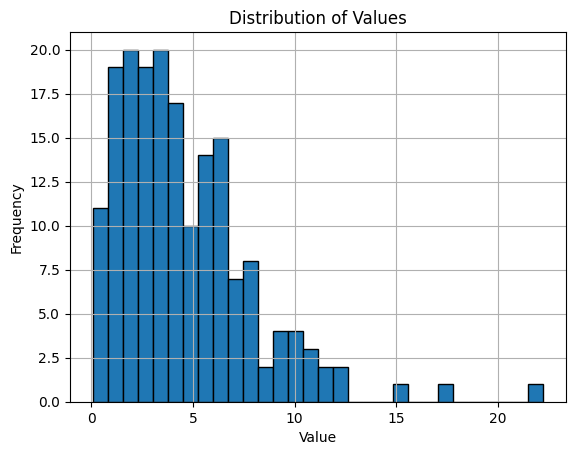

In [675]:
# Plot histogram
plt.hist(mahalanobis, bins=30, edgecolor='black') 
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

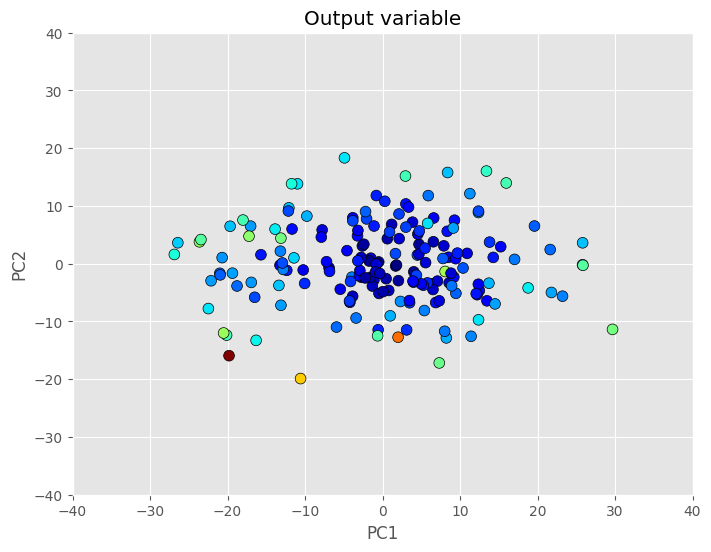

In [676]:
colors = [plt.cm.jet(float(i)/max(mahalanobis)) for i in mahalanobis]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim((-40, 40))
    plt.ylim((-40, 40))
    plt.title('Output variable')
plt.show()

In [677]:
from scipy.stats import chi2

threshold = chi2.ppf(0.99, df=n_components_95)
outliers = mahalanobis > threshold
outlier_indices_input = np.where(outliers)[0]

print("Outlier indices:", outlier_indices_input)

Outlier indices: [ 22  45 142]


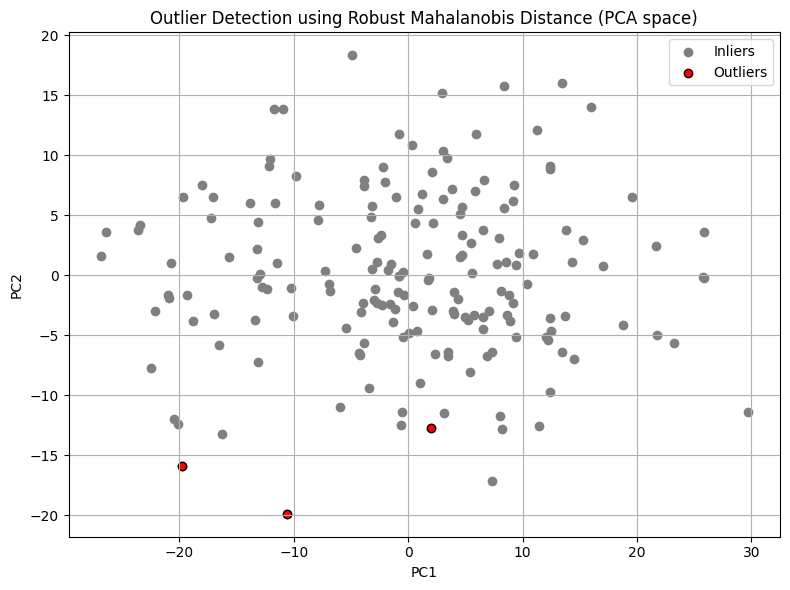

In [678]:
plt.figure(figsize=(8, 6))
plt.scatter(T[:, 0], T[:, 1], c='gray', label='Inliers')
plt.scatter(T[outliers, 0], T[outliers, 1], c='red', label='Outliers', edgecolors='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Outlier Detection using Robust Mahalanobis Distance (PCA space)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Outlier removal from multiple references

Let's repeat the same exercise for our output variables. Since we only have two target variables it does not make sense to compute PCA, since it's a dimension-reduction technique. Let's compute mahalanobis distance based on rbust covariance matrix of the output variables.

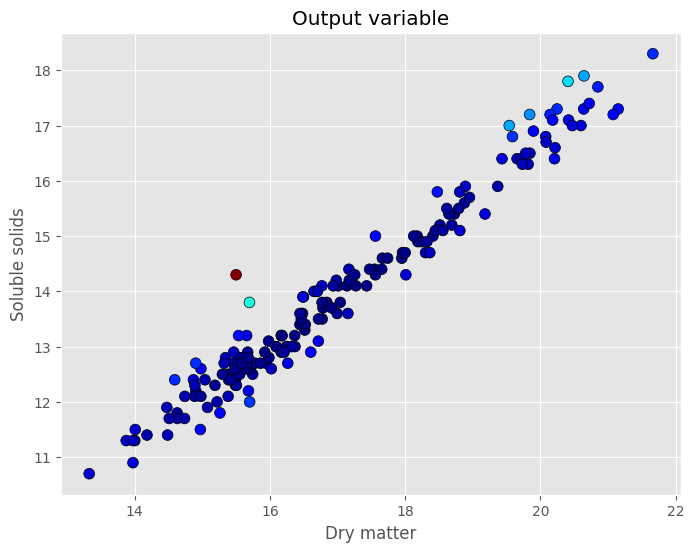

In [679]:
robust_cov = MinCovDet(random_state=42).fit(reference_values)

mahalanobis = robust_cov.mahalanobis(reference_values)

colors = [plt.cm.jet(float(i)/max(mahalanobis)) for i in mahalanobis]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(reference_values[:, 0], reference_values[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('Dry matter')
    plt.ylabel('Soluble solids')
    plt.title('Output variable')
plt.show()

In [680]:
threshold = chi2.ppf(0.99, df=2)
outliers = mahalanobis > threshold
outlier_indices_output = np.where(outliers)[0]

print("Outlier indices (based on output variables):", outlier_indices_output)

Outlier indices (based on output variables): [ 35  71  77 100 135 150 154 155 159]


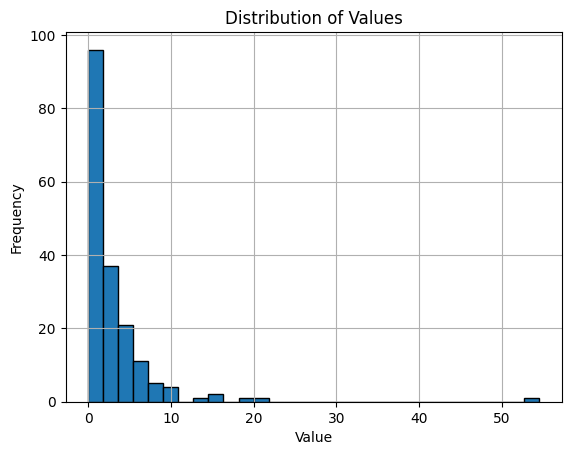

In [681]:
# Plot histogram
plt.hist(mahalanobis, bins=30, edgecolor='black')  
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

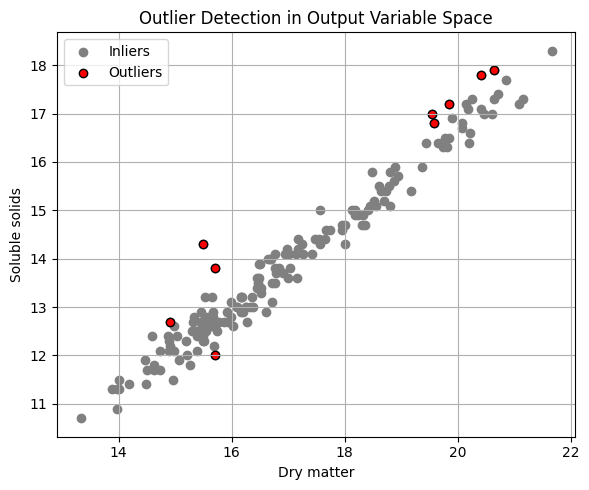

In [682]:
plt.figure(figsize=(6, 5))
plt.scatter(reference_values[:, 0], reference_values[:, 1], c='gray', label='Inliers')
plt.scatter(reference_values[outliers, 0], reference_values[outliers, 1], c='red', edgecolors='k', label='Outliers')
plt.xlabel('Dry matter')
plt.ylabel('Soluble solids')
plt.title('Outlier Detection in Output Variable Space')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Outlier removal from single reference value

Using the mean ± 3 standard deviations (3σ rule) is a common and simple method based on the assumption that the data is approximately normally distributed. In a normal distribution about 99.7% of the data falls within ±3 standard deviations from the mean.

Values beyond this range are considered statistically rare and often indicative of outliers.

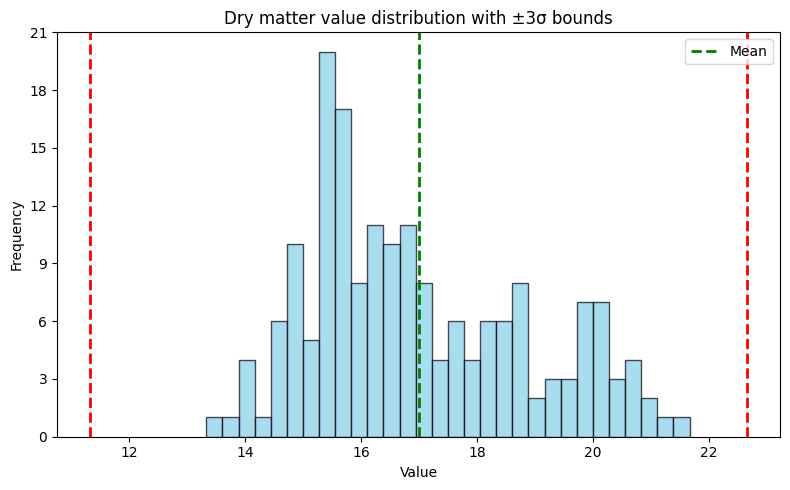

Outlier indices: []


In [683]:
# Let's say we choose Dry Matter as our target output variable
reference = reference_values[:,0]

# Compute mean and standard deviation
mean = np.mean(reference)
std = np.std(reference)

# Define bounds
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

plt.figure(figsize=(8, 5))
plt.hist(reference, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mean, color='green', linestyle='--', linewidth=2, label='Mean')
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2)
plt.axvline(upper_bound, color='red', linestyle='--', linewidth=2)
plt.title('Dry matter value distribution with ±3σ bounds')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


outlier_indices_single_reference = np.where((reference < lower_bound) | (reference > upper_bound))[0]
print("Outlier indices:", outlier_indices_single_reference)

In [684]:
# Combine unique outlier indices from both sources
combined_outliers = np.union1d(outlier_indices_input, outlier_indices_output)

# Remove those rows from input and output data
X_clean = np.delete(kiwi_spectra, combined_outliers, axis=0)
Y_clean = np.delete(reference, combined_outliers, axis=0)

print(f"Removed {len(combined_outliers)} outliers. Cleaned data shape:")
print("X_clean:", X_clean.shape)
print("Y_clean:", Y_clean.shape)

Removed 12 outliers. Cleaned data shape:
X_clean: (168, 224)
Y_clean: (168,)


## Pre-processing of data

### Smoothing

In [685]:
from scipy.signal import savgol_filter
 
X_example = X_clean[0, :]

w = 13
p = 2
X_smooth_1 = savgol_filter(X_example, w, polyorder = p, deriv=0)

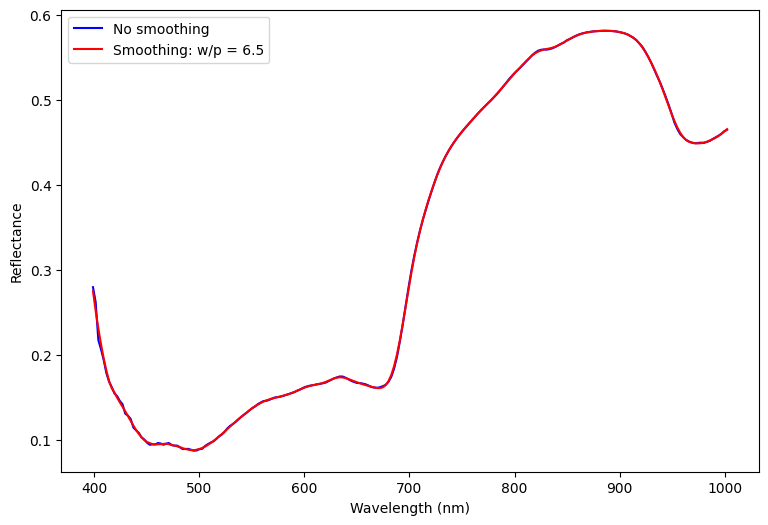

In [686]:
plt.figure(figsize=(9,6))
interval = np.arange(0,224,1)
plt.plot(wl[interval], X_example[interval], 'b', label = 'No smoothing')
plt.plot(wl[interval], X_smooth_1[interval], 'r', label = f'Smoothing: w/p = {w/p}')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.show()

## Scatter correction

In [687]:
def snv(input_data):
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [688]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

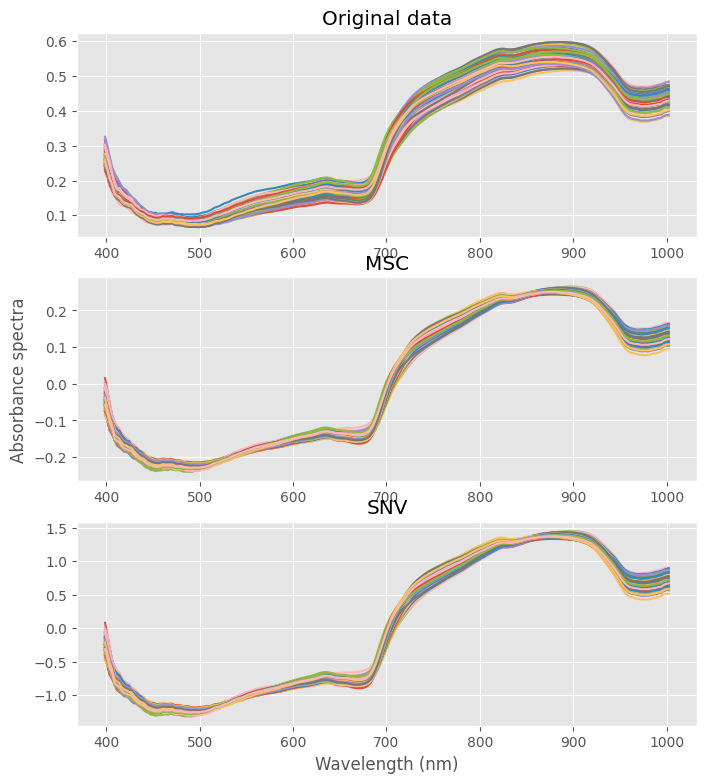

In [689]:
import matplotlib.pyplot as plt
 
Xmsc = msc(X_clean.copy())[0] # Take the first element of the output tuple
Xsnv = snv(X_clean.copy())
 
## Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(311)
    plt.plot(wl, X_clean.T)
    plt.title('Original data')
 
    ax2 = plt.subplot(312)
    plt.plot(wl, Xmsc.T)
    plt.ylabel('Absorbance spectra')
    plt.title('MSC')
 
    ax2 = plt.subplot(313)
    plt.plot(wl, Xsnv.T)
    plt.xlabel('Wavelength (nm)')
    plt.title('SNV')
    plt.show()

### Derivative

What did we mean with derivative? is it best to take derivative of the signal? it seems you can supply derivative order to savitzky-golay. Should I just tell what information can be gathered from 1st and 2nd derivative?

Delect SNV and do 1st and 2nd derivative, the modelling then can be done on some 

## Data partition

Kennard-Stone partition

In [690]:
import kennard_stone as ks
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate

X_cal, X_test, y_cal, y_test = ks.train_test_split(X_clean, Y_clean, test_size = 0.2)

/home/liza/miniforge3/envs/hyperspectral311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-06-13 16:16:51,840 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

/home/liza/miniforge3/envs/hyperspectral311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-06-13 16:16:51,842 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

/home/liza/miniforge3/envs/hyperspectral311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


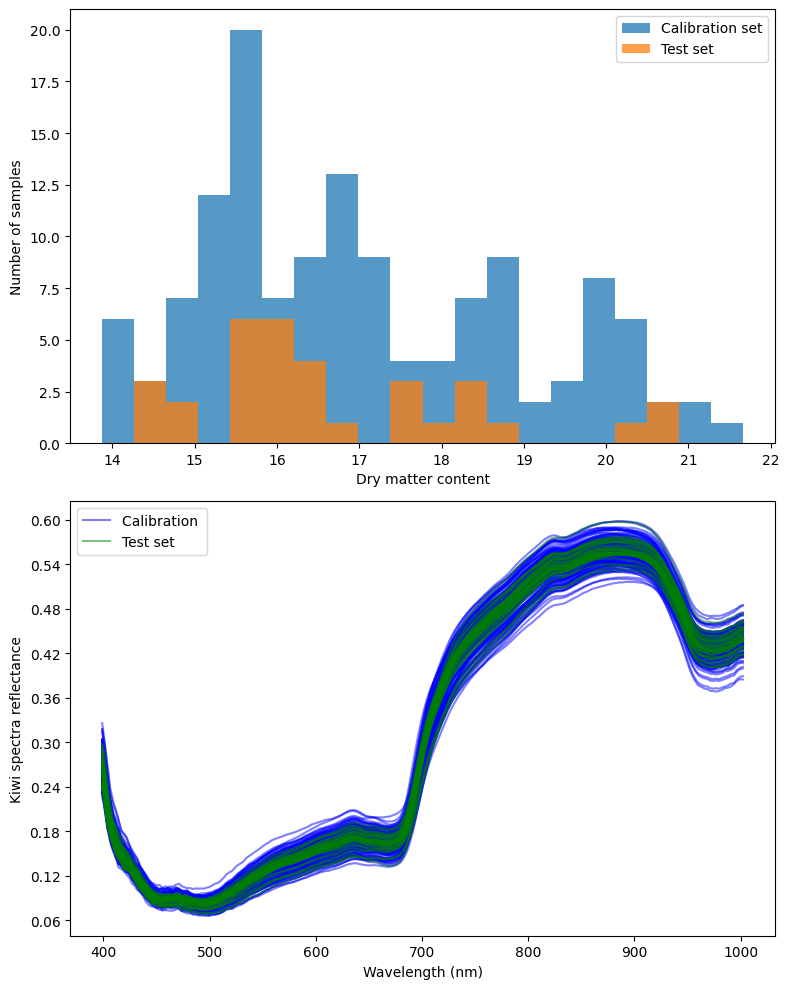

In [691]:
f, axs = plt.subplots(2,1,figsize=(8,10))
n, bins, patches = axs[0].hist(y_cal, bins = 20, alpha=0.75, label="Calibration set")
axs[0].hist(y_test, bins = bins, alpha=0.75, label="Test set")
axs[0].legend()
axs[0].set_xlabel("Dry matter content") 
axs[0].set_ylabel("Number of samples")

train_legend =  np.repeat("_Calibration", X_cal.shape[0])
train_legend[0] = "Calibration set"
test_legend =  np.repeat("_Test set", X_test.shape[0])
test_legend[0] = "Test set"

axs[1].plot(wl, X_cal.T, 'b', alpha=0.5, label = train_legend)
axs[1].plot(wl, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[1].legend()
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Kiwi spectra reflectance")
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

Duplex partition (some more coming)

In [692]:
# add https://github.com/yuerongz/DUPLEX-data-split-function


In [693]:
# add spxy https://github.com/hxhc/hxhc.github.io/issues/12

### Automated pre-processing (nippy) 

In [694]:
# jtorniainen // UEF
# 2019, MIT License

import nippy

pipelines = nippy.read_configuration('example_pipelines.ini')

# 2. Load data
data = X_cal.T #nippy works with the format where Rows = wavelength, Columns = samples

processed_data = nippy.nippy(wl, data, pipelines)
len(processed_data)

Running pipe 1:
{'MSC': {}, 'SAVGOL': {'deriv_order': 2, 'filter_win': 5, 'poly_order': 2}, 'SNV': None}

Running pipe 2:
{'MSC': None, 'SAVGOL': {'deriv_order': 0, 'filter_win': 11, 'poly_order': 2}, 'SNV': {}}

Running pipe 3:
{'MSC': {}, 'SAVGOL': {'deriv_order': 1, 'filter_win': 11, 'poly_order': 2}, 'SNV': None}

Running pipe 4:
{'MSC': None, 'SAVGOL': {'deriv_order': 0, 'filter_win': 7, 'poly_order': 2}, 'SNV': {}}

Running pipe 5:
{'MSC': None, 'SAVGOL': {'deriv_order': 0, 'filter_win': 7, 'poly_order': 2}, 'SNV': None}

Running pipe 6:
{'MSC': {}, 'SAVGOL': {'deriv_order': 0, 'filter_win': 11, 'poly_order': 2}, 'SNV': None}

Running pipe 7:
{'MSC': None, 'SAVGOL': {'deriv_order': 2, 'filter_win': 13, 'poly_order': 2}, 'SNV': None}

Running pipe 8:
{'MSC': None, 'SAVGOL': {'deriv_order': 2, 'filter_win': 11, 'poly_order': 2}, 'SNV': {}}

Running pipe 9:
{'MSC': {}, 'SAVGOL': {'deriv_order': 2, 'filter_win': 7, 'poly_order': 2}, 'SNV': None}

Running pipe 10:
{'MSC': None, 'SAVGO

39

/tmp/ipykernel_1546/518507249.py:14: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(processed_spectra[i][0], processed_spectra[i][1][:, sample_idx], label=pipelines[i])
/tmp/ipykernel_1546/518507249.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


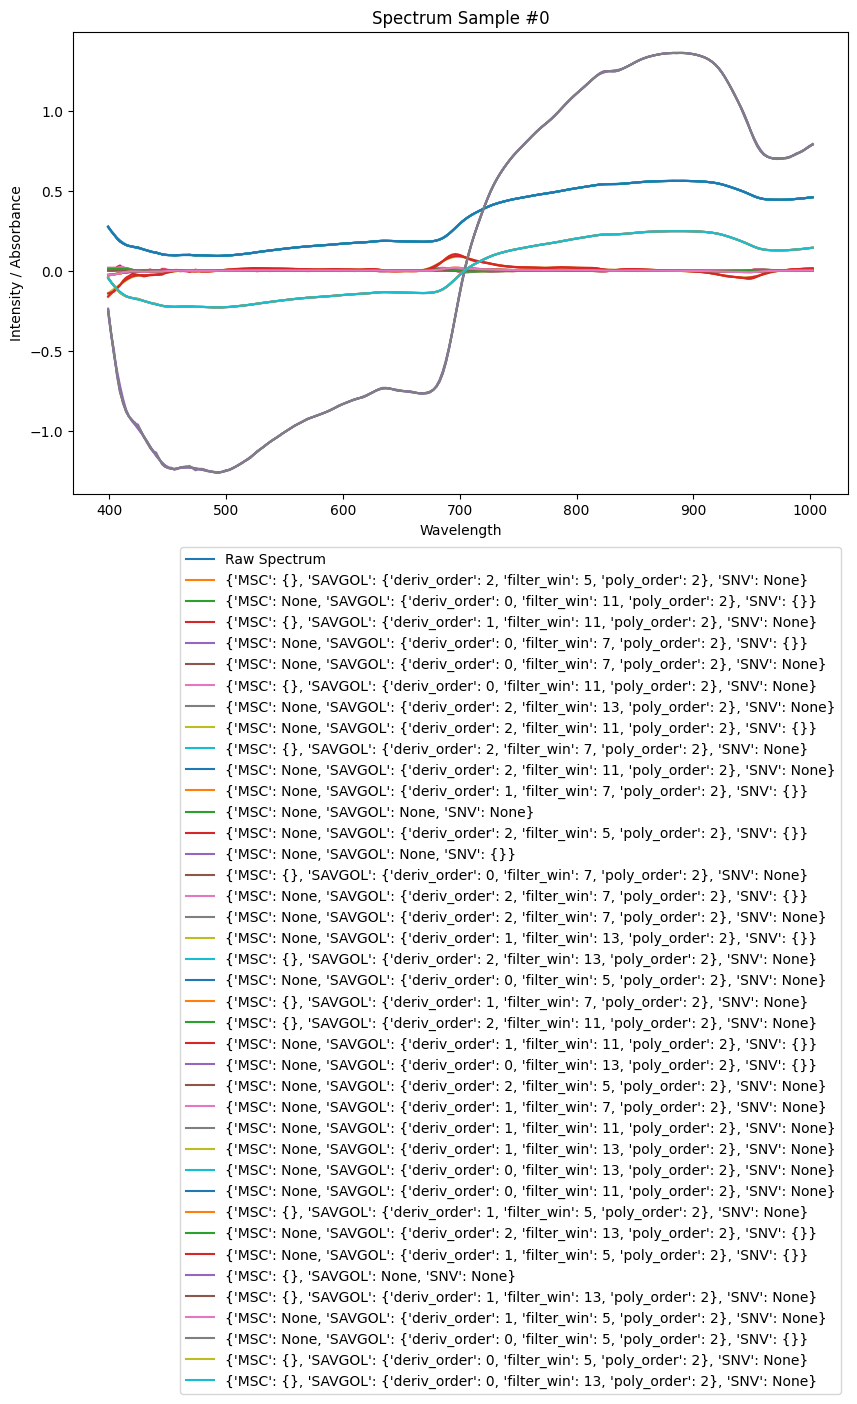

In [695]:
def plot_spectra(wavelength, raw_spectra, processed_spectra, pipelines, sample_idx=0):
    """
    Plot raw and preprocessed spectra for a given sample index.

    Args:
        wavelength (np.ndarray): Vector of wavelengths.
        raw_spectra (np.ndarray): Raw spectra matrix (wavelength x samples).
        processed_spectra (np.ndarray): Processed spectra matrix.
        sample_idx (int): Index of the sample to plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, raw_spectra[:, sample_idx], label='Raw Spectrum')
    for i in range(len(processed_spectra)):
        plt.plot(processed_spectra[i][0], processed_spectra[i][1][:, sample_idx], label=pipelines[i])
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity / Absorbance')
    plt.title(f'Spectrum Sample #{sample_idx}')
    plt.legend(bbox_to_anchor=(1,-0.1))
    plt.tight_layout()
    plt.show()

# Example usage:
# wavelength, raw_spectra are your data
# processed_spectra = ... (result of your preprocessing pipeline)
plot_spectra(wl, data, processed_data, pipelines, sample_idx=0)

In [696]:
from sklearn.model_selection import cross_val_score


def evaluate_plsr_across_pipelines(processed_spectra, y, pipelines, max_components=20, cv=5):
    """
    Evaluate PLSR on multiple preprocessed datasets, return the best one based on minimum CV error.
    
    Args:
        processed_spectra (list): List of (wavelength, spectra_matrix) tuples.
        y (np.ndarray): Target vector of shape (n_samples,).
        pipelines (list): List of pipelines.
        max_components (int): Max number of PLS components to try.
        cv (int): Number of CV folds.

    Returns:
        best_pipeline_name (str)
        best_spectra (np.ndarray)
        best_n_components (int)
        cv_errors_all (dict): Mean CV errors for each pipeline
    """
    cv_errors_all = {}
    best_score = np.inf
    best_pipeline_name = None
    best_spectra = None
    best_n_components = None
    best_pipeline_index = None

    for i, (wl, spectra) in enumerate(processed_spectra):
        X = spectra.T  # shape (n_samples, n_features)
        errors = []

        for n_comp in range(1, min(max_components, X.shape[1]) + 1):
            pls = PLSRegression(n_components=n_comp)
            neg_mse = cross_val_score(pls, X, y, cv=cv, scoring='neg_mean_squared_error')
            mean_mse = -np.mean(neg_mse)
            errors.append(mean_mse)

        pipeline_name = str(pipelines[i])
        cv_errors_all[pipeline_name] = errors
        min_error = min(errors)
        if min_error < best_score:
            best_score = min_error
            best_pipeline_name = pipelines[i]
            best_spectra = spectra
            best_pipeline_index = i
            best_n_components = errors.index(min_error) + 1

    return best_pipeline_name, best_spectra, best_n_components, cv_errors_all, best_pipeline_index

In [697]:
best_pipeline, best_data, n_comp, all_errors, best_pipeline_idx = evaluate_plsr_across_pipelines(
    processed_spectra=processed_data,
    y=y_cal,
    pipelines=pipelines,
    max_components=20,
    cv=5
)

print(f"Best pipeline: {best_pipeline} with {n_comp} components")

Best pipeline: {'MSC': None, 'SAVGOL': {'deriv_order': 0, 'filter_win': 13, 'poly_order': 2}, 'SNV': {}} with 15 components


In [698]:
X_cal = processed_data[best_pipeline_idx][1].T
wl, X_test = nippy.run_pipeline(wl, X_test.T, best_pipeline)
X_test = X_test.T

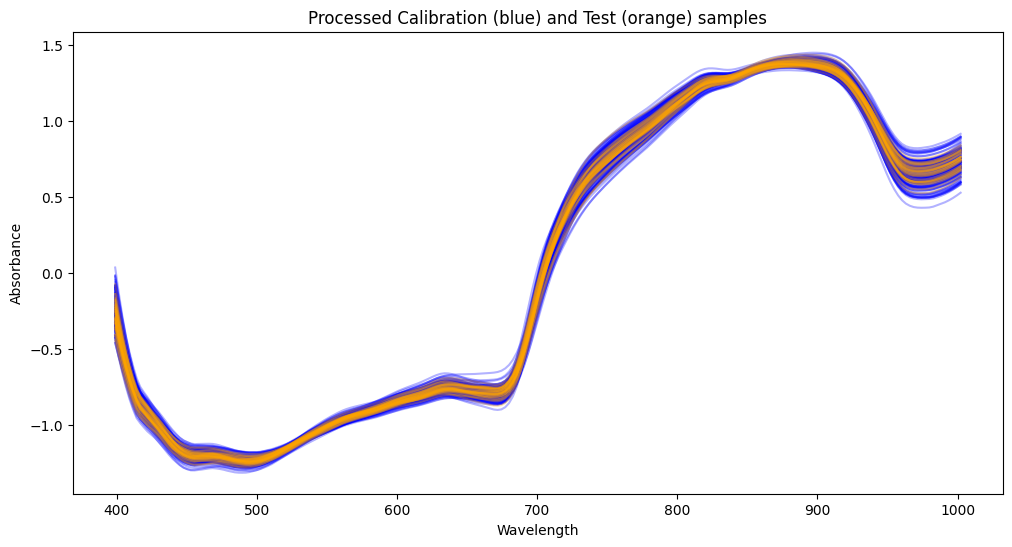

In [742]:
plt.figure(figsize=(12, 6))

# Plot calibration samples
for i in range(X_cal.shape[0]):
    plt.plot(wl, X_cal[i, :], color='blue', alpha=0.3)
    
# Plot test samples
for i in range(X_test.shape[0]):
    plt.plot(wl,X_test[i, :], color='orange', alpha=0.3)

plt.title('Processed Calibration (blue) and Test (orange) samples')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.show()

## Spectral calibration

### Principal component regression

In [700]:
# Define the PCA object
pca = PCA()

standard_scaler_cal = StandardScaler().fit(X_cal[:,:])

# Preprocess (2) Standardize features by removing the mean and scaling to unit variance
Xstd = standard_scaler_cal.transform(X_cal[:,:])
 
# Run PCA producing the reduced variable Xreg and select the first N pc components
Xreg = pca.fit_transform(Xstd)[:,:n_components_95]

In [701]:
from sklearn.metrics import r2_score, root_mean_squared_error

def plot_cv_vs_test(y_cal, y_cv, y_test, y_test_pred):
    """
    Plot a comparison of cross-validated vs. test set predictions.

    Parameters
    ----------
    y_cal : array-like, shape (n_samples_cal,)
        True target values for the calibration (training) set.
    y_cv : array-like, shape (n_samples_cal,)
        Cross-validated predicted values for the calibration set.
    y_test : array-like, shape (n_samples_test,)
        True target values for the test set.
    y_test_pred : array-like, shape (n_samples_test,)
        Predicted values for the test set.
    """
    # Compute metrics if not provided
    r2_cv = r2_score(y_cal, y_cv)
    rmse_cv = root_mean_squared_error(y_cal, y_cv)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)

    # Prepare figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Combined axis limits
    all_actual = np.concatenate([y_cal, y_test])
    all_pred = np.concatenate([y_cv, y_test_pred])
    vmin = min(all_actual.min(), all_pred.min())
    vmax = max(all_actual.max(), all_pred.max())

    # Plot CV
    axs[0].scatter(y_cal, y_cv, alpha=0.6)
    axs[0].plot([vmin, vmax], [vmin, vmax], 'k--', lw=2)
    axs[0].set_title('Cross-Validated Predictions')
    axs[0].set_xlabel('Actual')
    axs[0].set_ylabel('Predicted')
    axs[0].set_aspect('equal', 'box')
    axs[0].text(0.05, 0.95, f"R² = {r2_cv:.2f}\nRMSE = {rmse_cv:.2f}",
                transform=axs[0].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Plot Test
    axs[1].scatter(y_test, y_test_pred, alpha=0.6, color='orange')
    axs[1].plot([vmin, vmax], [vmin, vmax], 'k--', lw=2)
    axs[1].set_title('Test Predictions')
    axs[1].set_xlabel('Actual')
    axs[1].set_ylabel('Predicted')
    axs[1].set_aspect('equal', 'box')
    axs[1].text(0.05, 0.95, f"R² = {r2_test:.2f}\nRMSE = {rmse_test:.2f}",
                transform=axs[1].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Set same limits
    for ax in axs:
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)

    plt.tight_layout()
    plt.show()

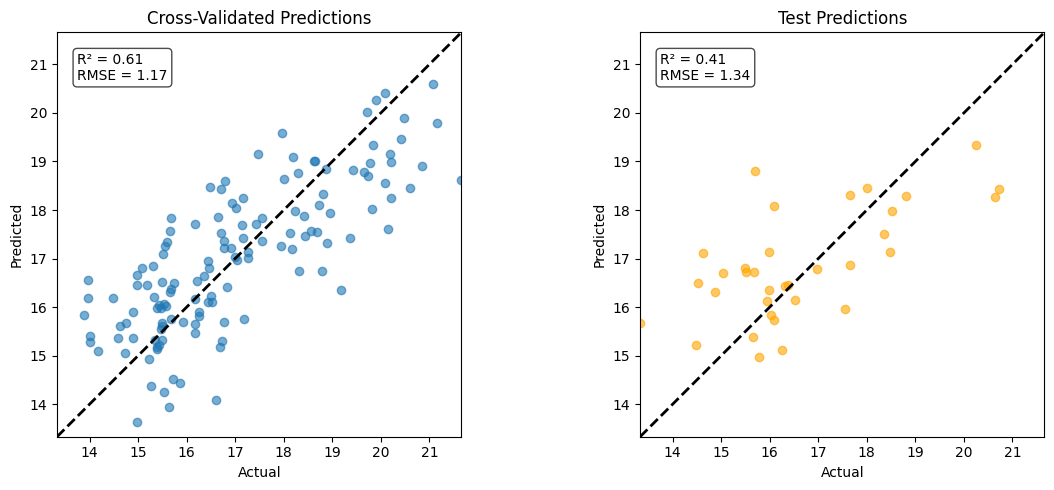

In [702]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict

# Cross-validation prediction on training set
y_cv = cross_val_predict(linear_model.LinearRegression(), Xreg, y_cal, cv=10)

X_test_std = standard_scaler_cal.transform(X_test)
X_test_reg = pca.transform(X_test_std)[:,:n_components_95]

# Fit model on full calibration set
model = linear_model.LinearRegression()
model.fit(Xreg, y_cal)

# Predict on test set
y_test_pred = model.predict(X_test_reg)

plot_cv_vs_test(y_cal, y_cv, y_test, y_test_pred)

### PLSR 

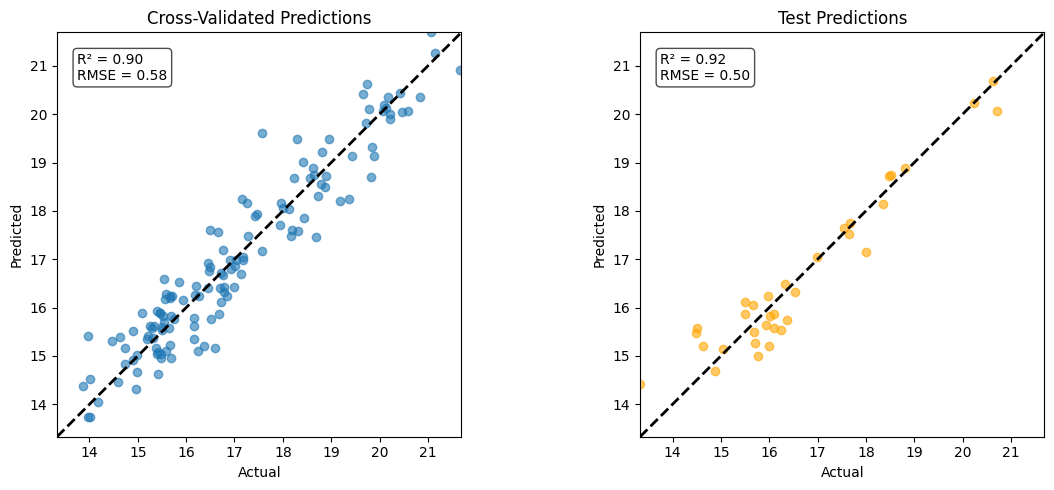

In [703]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
 
# Define PLS object
pls = PLSRegression(n_components=n_comp)
 
# Cross-validation
y_cv = cross_val_predict(pls, X_cal, y_cal, cv=10)
pls.fit(X_cal, y_cal)
y_test_pred = pls.predict(X_test) 

plot_cv_vs_test(y_cal, y_cv, y_test, y_test_pred)

## Model diagnostics

In [704]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

def optimise_pls_cv_test(X_train, y_train, X_test, y_test, n_comp):
    """
    Run PLS with multiple outputs, using cross-validation to compute MSE for each number of components.
    Also evaluate and plot test set performance.
    
    Parameters
    ----------
    X_train : array-like, shape (n_samples_train, n_features)
        Calibration (training) features.
    y_train : array-like, shape (n_samples_train, n_targets)
        Calibration (training) target(s).
    X_test : array-like, shape (n_samples_test, n_features)
        Test set features.
    y_test : array-like, shape (n_samples_test, n_targets)
        Test set target(s).
    n_comp : int
        Maximum number of PLS components to try.
    
    Returns
    -------
    n_comp: int of optimal number of PLS components
    """
    rmse_cv = []
    rmse_test = []
    rmse_train = []
    components = np.arange(1, n_comp + 1)

    for i in components:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
        rmse_cv.append(root_mean_squared_error(y_train, y_cv))
        pls = PLSRegression(n_components=i)
        pls.fit(X_train, y_train)
        y_train_pred = pls.predict(X_train)
        y_test_pred = pls.predict(X_test)
        rmse_train.append(root_mean_squared_error(y_train, y_train_pred))
        rmse_test.append(root_mean_squared_error(y_test, y_test_pred))
        sys.stdout.write(f"\r{i/n_comp*100:.1f}% completed")
        sys.stdout.flush()
    sys.stdout.write("\n")

    best_idx = int(np.argmin(rmse_cv))
    best_n = best_idx + 1
    print("Suggested number of components:", best_n)

    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 5))
        plt.plot(components, rmse_train, label='Training RMSE', marker='o', color='green')
        plt.plot(components, rmse_cv, label='CV RMSE', marker='o', color='red')
        plt.plot(components, rmse_test, marker='o', color='blue', label='Test RMSE')
        plt.xlabel('Number of PLS Components')
        plt.ylabel('Mean Squared Error')
        plt.title('Bias-Variance Trade-off in PLS')
        plt.legend()
        plt.grid(True)
        plt.show()
    return best_n

100.0% completed
Suggested number of components: 17


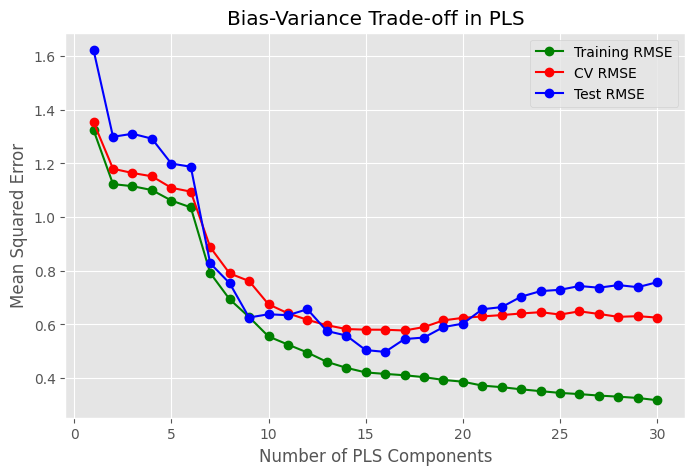

In [705]:
opt_n_comp = optimise_pls_cv_test(X_cal, y_cal, X_test, y_test, n_comp=30)

## Supervised outlier removal with PLS

In Partial Least Squares (PLS) regression, selecting the right number of components is crucial to balance underfitting and overfitting. The bias–variance plot shows how training error and cross-validation error change as model complexity increases:

- When using too few components, the model is too simple to capture patterns in the data, resulting in high training and CV error — this is underfitting.

- As you increase the number of components, the model captures more variance in the data, reducing training error.

- Eventually, the model may begin to overfit, capturing noise in the training set. This causes CV error to increase even though training error continues to fall.

The optimal number of PLS components is where the CV error reaches its minimum. This is the point of best generalization to unseen data. If multiple component counts give similar (flat) CV error, prefer the simpler model (with fewer components).

In [706]:
# Define PLS object
ncomp = opt_n_comp
pls = PLSRegression(n_components=ncomp)
# Fit data
pls.fit(X_cal, y_cal)
 
# Get X scores
T = pls.x_scores_
# Get X loadings
P = pls.x_loadings_
 
# Calculate error array
Err = X_cal - np.dot(T,P.T)
 
# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)
 
# Calculate Hotelling's T-squared (note that data are normalised by default)
Tsq = np.sum((pls.x_scores_/np.std(pls.x_scores_, axis=0))**2, axis=1)

In [707]:
# set the confidence level
conf = 0.95
 
from scipy.stats import f
# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
            dfd=(X_cal.shape[0]-ncomp))*ncomp*(X_cal.shape[0]-1)/(X_cal.shape[0]-ncomp)
 
# Estimate the confidence level for the Q-residuals
i = np.max(Q)+1
while 1-np.sum(Q>i)/np.sum(Q>0)> conf:
    i -= 1
Q_conf = i

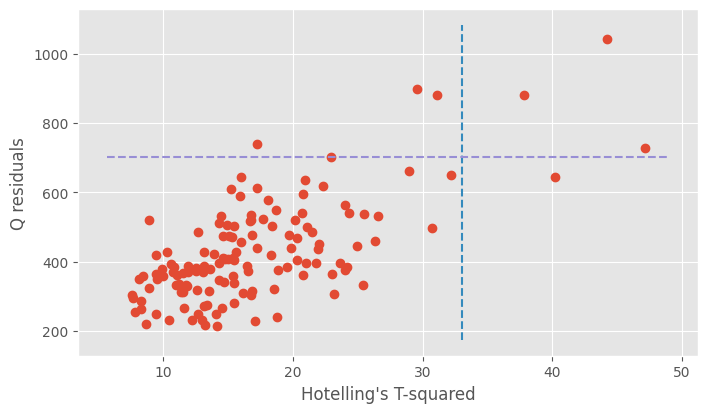

In [708]:
ax = plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(Tsq, Q, 'o')
 
    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
 
plt.show()

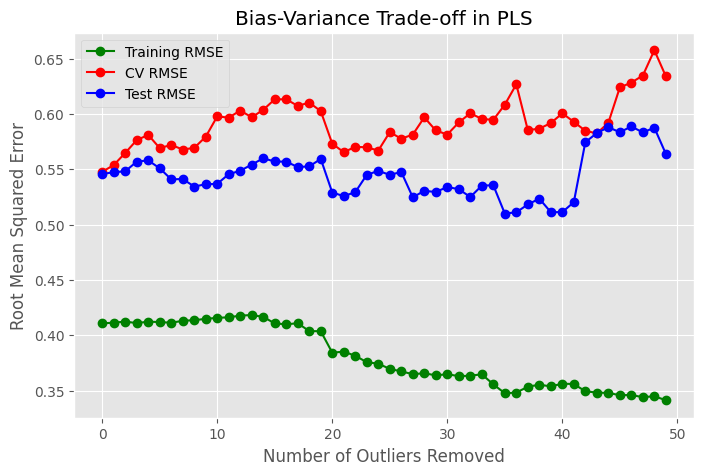

In [709]:
# Calculate RMS distance and sort in descending order
rms_values = np.sqrt(Q**2 + Tsq**2)
rms_dist = np.argsort(rms_values)[::-1]  # Descending order

# Sort calibration data
Xc = X_cal[rms_dist, :]
Yc = y_cal[rms_dist]

# Ensure we leave ≥5 samples for CV
n_cal = X_cal.shape[0]
max_outliers = 50  # Critical fix!

# Initialize arrays
rmse_cv = np.zeros(max_outliers)
rmse_test = np.zeros(max_outliers)
rmse_train = np.zeros(max_outliers)

for j in range(max_outliers):
    pls = PLSRegression(n_components=ncomp)
    X_curr = Xc[j:, :]
    Y_curr = Yc[j:]
    
    y_cv = cross_val_predict(pls, X_curr, Y_curr, cv=10)
    rmse_cv[j] = np.sqrt(mean_squared_error(Y_curr, y_cv))
    
    # Fit model and predict test/training sets
    pls.fit(X_curr, Y_curr)
    y_test_pred = pls.predict(X_test)
    rmse_test[j] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    y_train_pred = pls.predict(X_curr)
    rmse_train[j] = np.sqrt(mean_squared_error(Y_curr, y_train_pred))

# Find minimum RMSE (no need for non-zero check)
msemin = np.argmin(rmse_cv)  # Simpler and correct

# Plotting (unchanged)
with plt.style.context("ggplot"):
    plt.figure(figsize=(8, 5))
    plt.plot(range(max_outliers), rmse_train, label='Training RMSE', marker='o', color='green')
    plt.plot(range(max_outliers), rmse_cv, label='CV RMSE', marker='o', color='red')
    plt.plot(range(max_outliers), rmse_test, marker='o', color='blue', label='Test RMSE')
    plt.xlabel('Number of Outliers Removed')
    plt.ylabel('Root Mean Squared Error')
    plt.title('Bias-Variance Trade-off in PLS')
    plt.legend()
    plt.grid(True)
    plt.show()

In [710]:
msemin

np.int64(0)

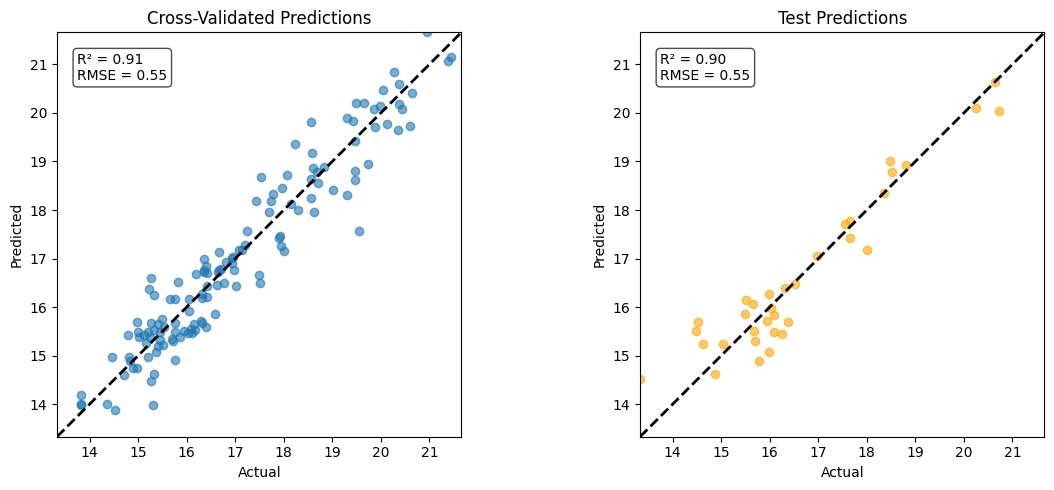

In [711]:
pls = PLSRegression(n_components=ncomp)
X_train = Xc[msemin:, :]
Y_train = Yc[msemin:]

# Cross-validation prediction
y_cv = cross_val_predict(pls, X_train, Y_train, cv=10)

# Calibration prediction
pls.fit(X_train, Y_train)
y_test_pred = pls.predict(X_test)
plot_cv_vs_test(y_cv, Y_train, y_test, y_test_pred)

## Deep learning methods (simple convolution)

In [736]:
import tensorflow as tf
from tensorflow.keras import regularizers

model = tf.keras.Sequential([
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.Dense(16, activation='relu'),
tf.keras.layers.Dense(4,  activation='relu'),
tf.keras.layers.Dense(1, activation="linear")])

In [737]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
scaler.fit(X_cal)
Xs_train = scaler.transform(X_cal)
Xs_test = scaler.transform(X_test)

In [738]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [739]:
history = model.fit(Xs_train, y_cal, epochs=500,
            validation_data=(Xs_test, y_test),
            verbose=1)



Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 14.8255 - val_loss: 3.3872
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5266 - val_loss: 2.3157
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9857 - val_loss: 2.2454
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9828 - val_loss: 2.2012
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5806 - val_loss: 1.5267
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6219 - val_loss: 1.8640
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4097 - val_loss: 1.4305
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3745 - val_loss: 1.6793
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2202 - val_loss: 1.1913
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0554 - val_loss: 1.2886
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0481 - val_loss: 1.1389
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0728 - val_l

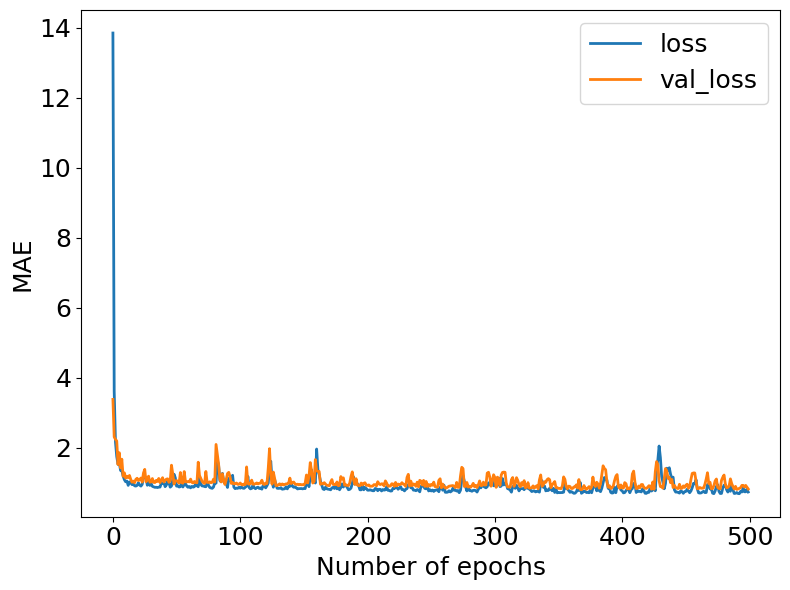

In [740]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], linewidth=2, label='loss')
ax.plot(history.history['val_loss'], linewidth=2, label='val_loss')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel('Number of epochs',fontsize=18)
ax.set_ylabel('MAE',fontsize=18)
plt.legend(fontsize=18)

plt.tight_layout()
plt.show()

#TODO rmse as loss function and also test set (Kennard stone for example)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f151142bf60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


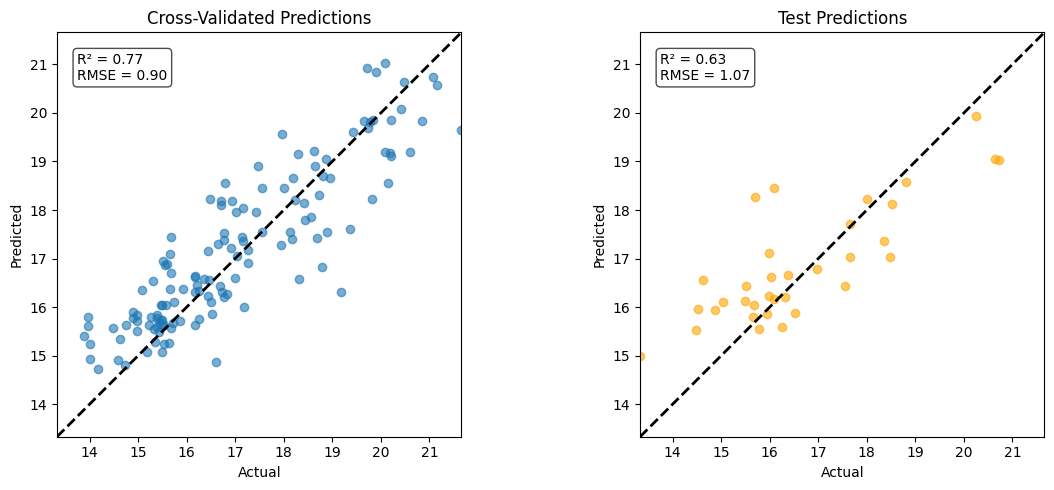

In [741]:
test_predictions = model.predict(Xs_test)
train_predictions = model.predict(Xs_train)
plot_cv_vs_test(y_cal, train_predictions, y_test, test_predictions)

